# INTRODUCTION & TUTORIAL TO SEGMENTATION HANDLER

### Component Overview

![Component Overview including Segmentation Handler](../../docs/img/component_overview_incl_seg_handler.png)

### Introduction to the "Segmentation Handler" Layer

The ```SegmentationHandler``` essentially is another component in the ```ExplanationGenerator``` that applies a segmentation algorithm on the image to be explained with the resulting segments being the new object of optimization and thus of the explanation. It is parsed to the ```ExplanationGenerator``` via arguments just as with the other established components (optimizer, gradient method, ...). 

Internally, each segment is allocated a label with corresponding label image - an image of the original size, consisting only of the allocated partition of the image, the rest being filled with zeros. A new encoded representation of the original image, a weight vector for the label images made up of all ones, is then passed for further processing.

During explanation generation, whenever neccessary, a dedicated loss function can call ```BaseSegmentationHandler.generate_img_from_weight_vector()``` to decode the encoded image.

Further down the tutorial, you will find a generated result where one can observe how an image could be segmented.

**Overview of the implemented segmentation algorithms**:
</br>
https://tuananhroman.github.io/empaia_max_pydoc/lib/image_segmentation/index.html

**Overview of compatible loss functions**:
</br>



## EXPLANATION GENERATION

Gitlab-Link to the Guided-Soft-Attention Repo: https://gitlab.dai-labor.de/empaia/guided-soft-attention/-/tree/master

#### 1. **Import required libraries**

In [1]:
import sys

sys.path.insert(1, "/home/tuananhroman/dai/guided-soft-attention")

import torch
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt

import maxi
from src.models.vit_gusa import ViTGuSA
from utils.loader import Loader
from utils.transform import transform
from src.visualization.visualize_attention import visualize_attention


2023-02-09 13:50:57.082340: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### 2. **Set path to the model weights and cell images**

In [2]:
path_to_model = "/home/tuananhroman/dai/guided-soft-attention/weights/model_vit_hd1_2.pth"
path_to_img = "/home/tuananhroman/dai/guided-soft-attention/data/image/image_3.jpg"


#### 3. **Load model and image**

In [3]:
# dev = "cuda" if torch.cuda.is_available() else "cpu"
dev = "cpu"
device = torch.device(dev)

# LOAD MODEL
model = ViTGuSA(4, dev, patch_size=8, freeze_backbone=True, head_depth=1)
model.load_state_dict(
    torch.load(
        path_to_model,
        map_location=device,
    )
)
model.to(device)

# LOAD IMAGE
img = Image.open(path_to_img)
# data specific preprocessing
img_transformed = transform(
    img, img_size=(img.size[0] // 4, img.size[1] // 4), patch_size=8
).unsqueeze(0)
img_transformed = img_transformed.to(device)

#### 4. **Chose desired component classes and configuration for the loss, optimizer and gradient**

In [16]:
# chose desired component classes for the loss, optimizer and gradient
loss_class = maxi.loss.SuperpixelLimeLoss
optimizer_class = maxi.optimizer.AdaExpGradOptimizer
gradient_class = maxi.gradient.LimeGradient

# specify the configuration for the components
loss_kwargs = {"n_samples": 100}
optimizer_kwargs = {
    "l1": 0.00000001,
    "l2": 0.00000001,
    "eta": 0.5,
    "channels_first": True,
}
gradient_kwargs = {}

# set segmentation algorithm with its parameters
sp_algorithm = maxi.image_segmentation.WatershedHandler
sp_kwargs = {
    "ms_spatial_radius": 16,
    "ms_color_radius": 36,
    "max_min_dist": 25
}

#### 5. **Instantiate the "ExplanationGenerator" with our settings**

In [ ]:
cem = maxi.ExplanationGenerator(
    loss=loss_class,
    optimizer=optimizer_class,
    gradient=gradient_class,
    loss_kwargs=loss_kwargs,
    sg_algorithm=sp_algorithm,
    optimizer_kwargs=optimizer_kwargs,
    gradient_kwargs=gradient_kwargs,
    sg_kwargs=sp_kwargs,
    num_iter=2000,
    save_freq=1000,
    verbose=True,
)

#### 6. **Define inference pre- and post-processing procedures**

In [10]:
# cast image to torch.float32 and to the correct device before inference
def preprocess(data):
    if type(data) is not torch.Tensor or data.dtype != torch.float32:
        return torch.tensor(data, dtype=torch.float32, device=device)
    if data.device != device:
        data = data.to(device)
    return data

# unsqueeze prediction to match the batch dimension
def un_squeeze(data):
    return data[0].unsqueeze(0) if data[0].ndim < 2 else data[0]

# wrap the model with the preprocess and un_squeeze functions
_model = maxi.inference.InferenceWrapper(
    model, quantizer=un_squeeze, preprocess=preprocess
)

#### 7. **Start the explanation procedure and retrieve the results**

In [4]:
results, _ = cem.run(image=img_transformed.cpu().numpy(), inference_call=_model)    

/home/tuananhroman/dai/MAXi-XAI-lib/src/maxi/lib/image_segmentation/watershed_handler.py:91: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(
/home/tuananhroman/.cache/pypoetry/virtualenvs/maxi-ZjBXp4XP-py3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/home/tuananhroman/.cache/pypoetry/virtualenvs/maxi-ZjBXp4XP-py3.8/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of n

[INFO] 14 unique segments found!
iteration:      1 || overall_loss:   640.3727 | attack_loss: 640.3727 | l1: 0.000000 | l2: 0.000000
iteration:      2 || overall_loss:   551.9146 | attack_loss: 550.7912 | l1: 1.123453 | l2: 0.000000
iteration:      3 || overall_loss:   485.2656 | attack_loss: 483.2435 | l1: 2.022131 | l2: 0.000000
iteration:      4 || overall_loss:   412.7031 | attack_loss: 409.6333 | l1: 3.069825 | l2: 0.000000
iteration:      5 || overall_loss:   348.4039 | attack_loss: 344.3264 | l1: 4.077499 | l2: 0.000000
iteration:      6 || overall_loss:   301.8762 | attack_loss: 297.0049 | l1: 4.871244 | l2: 0.000000
iteration:      7 || overall_loss:   269.3298 | attack_loss: 263.8627 | l1: 5.467115 | l2: 0.000000
iteration:      8 || overall_loss:   245.9850 | attack_loss: 240.0659 | l1: 5.919163 | l2: 0.000000
iteration:      9 || overall_loss:   228.6737 | attack_loss: 222.4038 | l1: 6.269861 | l2: 0.000000
iteration:     10 || overall_loss:   215.4039 | attack_loss: 208.85

/home/tuananhroman/dai/MAXi-XAI-lib/src/maxi/lib/computation_components/optimizer/ada_exp_grad.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  self.y[:] = 1.0 / self.t * self.x + (1 - 1.0 / self.t) * self.y


In [5]:
results.keys()

odict_keys(['1', '1000', '2000'])

# VISUALIZATION

In [6]:
import numpy as np
from matplotlib import pyplot as plt

def prepare_img(
    img: np.ndarray,
    to_cpu: bool=False, 
    squeeze: bool=True, 
    normalize: bool=True, 
    channels_first_to_last: bool=True
) -> np.ndarray:
    def NormalizeData(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))
    if to_cpu:
        img = img.cpu().numpy()
    if squeeze:
        img = img.squeeze(0)
    if channels_first_to_last:
        img = np.transpose(img, (1, 2, 0))
    if normalize:
        img = NormalizeData(img)
    return img

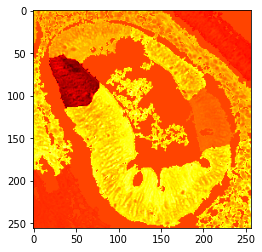

In [7]:
IMG_ITER = "2000"

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

plt.imshow(rgb2gray(prepare_img(results[IMG_ITER])), vmin=0, vmax=1, cmap="hot")

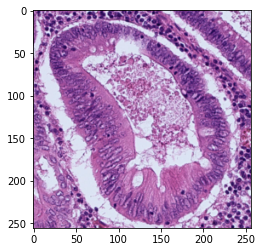

In [8]:
plt.imshow(prepare_img(img_transformed.cpu().numpy()))